<a href="https://colab.research.google.com/github/thuviettran/demo-github/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_B%E1%BA%A3n_sao_c%E1%BB%A7a_Ucelltitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import cv2
import numpy as np
import glob
from google.colab import drive
from tqdm import tqdm # Thư viện hiển thị thanh tiến độ
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import cv2
import numpy as np
import glob
from google.colab import drive
from tqdm import tqdm # Thư viện hiển thị thanh tiến độ

# 1. KẾT NỐI GOOGLE DRIVE
drive.mount('/content/drive')

# --- CẤU HÌNH ĐƯỜNG DẪN (BẠN HÃY KIỂM TRA KỸ DÒNG NÀY) ---
# Dựa trên ảnh bạn gửi, đường dẫn có thể là một trong hai dạng dưới đây.
# Hãy bỏ comment (xóa dấu #) ở dòng đúng với Drive của bạn:

# Dạng 1 (Thường gặp):
# BASE_PATH = '/content/drive/MyDrive/SHIDC-B-Ki-67/256x256 cropped images'

# Dạng 2 (Dựa theo ảnh chụp màn hình của bạn thấy thư mục lồng nhau):
BASE_PATH = '/content/drive/MyDrive/256x256 cropped images'

# Nơi sẽ lưu file .npy kết quả (để dùng cho train)
SAVE_DIR = '/content/drive/MyDrive/PathoNet_Input_Data'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# -----------------------------------------------------------

def create_mask_from_json(json_path, img_shape=(256, 256)):
    """
    Hàm đọc file JSON cụ thể của bạn và vẽ mask.
    Input: File json dạng list [{"x":..., "y":..., "label_id":...}]
    Output: Mask 2D (256x256) với giá trị pixel là 0, 1, 2, 3
    """
    # Tạo nền đen (class 0 - Background)
    mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)

    try:
        with open(json_path, 'r') as f:
            points = json.load(f) # Load trực tiếp thành List

        # Duyệt qua từng điểm trong danh sách
        for p in points:
            x = int(p.get('x', -1))
            y = int(p.get('y', -1))
            label = int(p.get('label_id', 0))

            # Kiểm tra tọa độ hợp lệ và vẽ
            if x >= 0 and y >= 0 and label > 0:
                # Vẽ hình tròn đặc bán kính 3px tại vị trí nhân tế bào
                # Màu vẽ chính là label_id (1, 2 hoặc 3)
                cv2.circle(mask, (x, y), 3, label, -1)

    except Exception as e:
        print(f"Lỗi khi đọc file {json_path}: {e}")

    return mask

def process_folder(folder_name, save_prefix):
    """
    Hàm duyệt thư mục ảnh và tạo file .npy
    """
    input_dir = os.path.join(BASE_PATH, folder_name)
    print(f"--- Đang xử lý thư mục: {input_dir} ---")

    image_paths = glob.glob(os.path.join(input_dir, "*.jpg"))

    if len(image_paths) == 0:
        print("CẢNH BÁO: Không tìm thấy ảnh .jpg nào! Hãy kiểm tra lại đường dẫn BASE_PATH.")
        return

    X_data = [] # Chứa ảnh
    Y_data = [] # Chứa nhãn (mask)

    for img_path in tqdm(image_paths):
        # 1. Xử lý Ảnh
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        # 2. Xử lý JSON tương ứng
        json_path = img_path.replace(".jpg", ".json")

        if os.path.exists(json_path):
            mask = create_mask_from_json(json_path, (256, 256))

            # Thêm vào list
            X_data.append(img)
            Y_data.append(mask)

    # Chuyển list thành Numpy Array
    X_arr = np.array(X_data, dtype=np.float32) / 255.0  # Chuẩn hóa về 0-1
    Y_arr = np.array(Y_data, dtype=np.float32)          # Giữ nguyên giá trị class 0,1,2,3

    # PathoNet yêu cầu mask có shape (N, 256, 256, 1)
    Y_arr = np.expand_dims(Y_arr, axis=-1)

    print(f"Hoàn thành {save_prefix}. Kích thước: X={X_arr.shape}, Y={Y_arr.shape}")

    # Lưu file
    np.save(os.path.join(SAVE_DIR, f'{save_prefix}_images.npy'), X_arr)
    np.save(os.path.join(SAVE_DIR, f'{save_prefix}_labels.npy'), Y_arr)

# --- CHẠY CHƯƠNG TRÌNH ---
# 1. Xử lý tập Train
process_folder('train256', 'train')

# 2. Xử lý tập Test (nếu muốn)
process_folder('test256', 'test')

print(f"\nĐã xong! Dữ liệu đã lưu tại: {SAVE_DIR}")

Mounted at /content/drive
--- Đang xử lý thư mục: /content/drive/MyDrive/256x256 cropped images/train256 ---


100%|██████████| 1656/1656 [01:22<00:00, 20.18it/s] 


Hoàn thành train. Kích thước: X=(1656, 256, 256, 3), Y=(1656, 256, 256, 1)
--- Đang xử lý thư mục: /content/drive/MyDrive/256x256 cropped images/test256 ---


100%|██████████| 700/700 [00:38<00:00, 18.38it/s]


Hoàn thành test. Kích thước: X=(700, 256, 256, 3), Y=(700, 256, 256, 1)

Đã xong! Dữ liệu đã lưu tại: /content/drive/MyDrive/PathoNet_Input_Data


In [ ]:
# 1. Clone code từ Github
%cd /content
!git clone https://github.com/SHIDCenter/PathoNet.git
%cd PathoNet

# 2. Tạo file config trỏ tới dữ liệu vừa tạo
# Lưu ý: batchSize = 8 để tránh lỗi tràn RAM trên Colab
config_text = """
class Config:
    def __init__(self):
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.model = "PathoNet"
        self.modelPath = "model_output"
        self.batchSize = 8
        self.epoches = 100
        self.learning_rate = 1e-4
"""
with open("config.py", "w") as f:
    f.write(config_text)



/content
Cloning into 'PathoNet'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 272 (delta 18), reused 13 (delta 13), pack-reused 246 (from 1)
Receiving objects: 100% (272/272), 3.18 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/PathoNet
2026-02-16 01:00:32.594410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771203632.635473    8768 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771203632.648226    8768 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771203632.677787    8768 computation_placer.cc:177] c

In [ ]:
# --- SCRIPT TỰ ĐỘNG SỬA LỖI MODEL.PY ---
import os

file_path = 'models.py'

# 1. Đọc nội dung file gốc
with open(file_path, 'r') as f:
    content = f.read()

# 2. Thực hiện thay thế dòng code lỗi
# Lỗi cũ: from keras.utils.layer_utils import get_source_inputs
# Sửa thành: truy cập trực tiếp vào thư viện nội bộ của Tensorflow
old_line = "from keras.utils.layer_utils import get_source_inputs"
new_line = "from tensorflow.python.keras.utils.layer_utils import get_source_inputs"

if old_line in content:
    content = content.replace(old_line, new_line)
    print("✅ Đã sửa lỗi import 'layer_utils' thành công!")
else:
    print("⚠️ Không tìm thấy dòng lỗi hoặc file đã được sửa trước đó.")

# 3. Sửa thêm các lỗi tương thích khác (nếu có)
# Chuyển đổi keras -> tensorflow.keras để ổn định hơn trên Colab mới
content = content.replace("import keras.backend as K", "import tensorflow.keras.backend as K")
content = content.replace("from keras.models import Model", "from tensorflow.keras.models import Model")
content = content.replace("from keras.layers import", "from tensorflow.keras.layers import")

# 4. Ghi đè lại file
with open(file_path, 'w') as f:
    f.write(content)

print("Đã cập nhật file models.py. Bạn hãy chạy lệnh train lại nhé!")

✅ Đã sửa lỗi import 'layer_utils' thành công!
Đã cập nhật file models.py. Bạn hãy chạy lệnh train lại nhé!


In [ ]:
import os

# --- CẤU HÌNH SỬA LỖI ---
file_to_fix = 'models.py'
train_file = 'train.py'

# 1. NỘI DUNG SỬA CHO MODELS.PY
# Chúng ta sẽ thay thế các dòng import cũ bằng import mới của Tensorflow 2
replacements = {
    # Sửa lỗi layer_utils
    "from keras.utils.layer_utils import get_source_inputs": "from tensorflow.python.keras.utils.layer_utils import get_source_inputs",

    # Sửa lỗi data_utils (Lỗi bạn vừa gặp trong ảnh)
    "from keras.utils.data_utils import get_file": "from tensorflow.keras.utils import get_file",

    # Sửa lỗi backend
    "import keras.backend as K": "import tensorflow.keras.backend as K",

    # Sửa lỗi models/layers chung
    "from keras.models import Model": "from tensorflow.keras.models import Model",
    "from keras.layers import": "from tensorflow.keras.layers import",
    "from keras.applications.imagenet_utils import _obtain_input_shape": "from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape",

    # Sửa lỗi BatchNormalization (thường gặp)
    "from keras.layers.normalization import BatchNormalization": "from tensorflow.keras.layers import BatchNormalization",
}

# 2. THỰC HIỆN SỬA FILE MODELS.PY
print(f"--- Đang sửa file {file_to_fix} ---")
try:
    with open(file_to_fix, 'r') as f:
        content = f.read()

    fixed_count = 0
    for old, new in replacements.items():
        if old in content:
            content = content.replace(old, new)
            fixed_count += 1
            print(f"✅ Đã sửa: {old.split(' import ')[0]}...")

    with open(file_to_fix, 'w') as f:
        f.write(content)

    if fixed_count == 0:
        print("ℹ️ File có vẻ đã được sửa trước đó hoặc không tìm thấy dòng code cũ.")
    else:
        print(f"🎉 Hoàn tất! Đã sửa {fixed_count} lỗi import.")

except FileNotFoundError:
    print(f"❌ Không tìm thấy file {file_to_fix}. Hãy chắc chắn bạn đang ở đúng thư mục PathoNet.")

# 3. SỬA LỖI SCIPY TRONG TRAIN.PY (Xử lý lỗi DeprecationWarning/AttributeError)
# Code cũ dùng scipy.misc.imread đã bị xóa. Ta sẽ thay bằng imageio hoặc cv2.
print(f"\n--- Đang xử lý lỗi Scipy trong {train_file} ---")
try:
    with open(train_file, 'r') as f:
        train_content = f.read()

    # Thêm đoạn code "vá" vào đầu file train.py để thay thế scipy.misc
    patch_code = """
import sys
import cv2
import numpy as np
# --- PATCH: GIẢ LẬP SCIPY.MISC CHO CODE CŨ ---
try:
    import scipy.misc
except ImportError:
    import types
    scipy.misc = types.ModuleType('scipy.misc')

# Định nghĩa lại hàm imread bằng OpenCV
if not hasattr(scipy.misc, 'imread'):
    def custom_imread(name, mode=None):
        img = cv2.imread(name)
        if img is None: return None
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scipy.misc.imread = custom_imread

if not hasattr(scipy.misc, 'imresize'):
    def custom_imresize(arr, size, interp='bilinear', mode=None):
        # Xử lý size dạng float (tỷ lệ) hoặc tuple (kích thước)
        if isinstance(size, float):
            return cv2.resize(arr, None, fx=size, fy=size)
        return cv2.resize(arr, size)
    scipy.misc.imresize = custom_imresize
# ---------------------------------------------
"""

    # Chỉ thêm patch nếu chưa có
    if "PATCH: GIẢ LẬP SCIPY.MISC" not in train_content:
        # Chèn vào sau các dòng import hệ thống (dòng đầu tiên)
        train_content = patch_code + "\n" + train_content

        with open(train_file, 'w') as f:
            f.write(train_content)
        print("✅ Đã chèn mã vá lỗi Scipy vào train.py")
    else:
        print("ℹ️ File train.py đã được vá lỗi Scipy trước đó.")

except FileNotFoundError:
    print(f"❌ Không tìm thấy file {train_file}.")

--- Đang sửa file models.py ---
✅ Đã sửa: from keras.utils.data_utils...
🎉 Hoàn tất! Đã sửa 1 lỗi import.

--- Đang xử lý lỗi Scipy trong train.py ---
✅ Đã chèn mã vá lỗi Scipy vào train.py


In [ ]:
import os

# --- SCRIPT SỬA LỖI TỰ ĐỘNG (AUTO-PATCH) ---
# 1. Sửa lỗi import trong models.py
model_file = 'models.py'
replacements = {
    "from keras.utils.layer_utils import get_source_inputs": "from tensorflow.python.keras.utils.layer_utils import get_source_inputs",
    "from keras.utils.data_utils import get_file": "from tensorflow.keras.utils import get_file",
    "import keras.backend as K": "import tensorflow.keras.backend as K",
    "from keras.models import Model": "from tensorflow.keras.models import Model",
    "from keras.layers import": "from tensorflow.keras.layers import",
    "from keras.applications.imagenet_utils import _obtain_input_shape": "from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape",
    "from keras.layers.normalization import BatchNormalization": "from tensorflow.keras.layers import BatchNormalization"
}

if os.path.exists(model_file):
    with open(model_file, 'r') as f:
        content = f.read()
    for old, new in replacements.items():
        content = content.replace(old, new)
    with open(model_file, 'w') as f:
        f.write(content)
    print("✅ Đã sửa xong lỗi thư viện Keras trong models.py")

# 2. Sửa lỗi Scipy trong train.py (Fix lỗi DeprecationWarning/AttributeError)
train_file = 'train.py'
if os.path.exists(train_file):
    with open(train_file, 'r') as f:
        content = f.read()

    # Chèn code giả lập Scipy nếu chưa có
    patch_code = """
import sys
import cv2
import numpy as np
import types
try:
    import scipy.misc
except ImportError:
    scipy.misc = types.ModuleType('scipy.misc')

if not hasattr(scipy.misc, 'imread'):
    scipy.misc.imread = lambda name, mode=None: cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) if cv2.imread(name) is not None else None
if not hasattr(scipy.misc, 'imresize'):
    scipy.misc.imresize = lambda arr, size, interp='bilinear', mode=None: cv2.resize(arr, (int(size[1]), int(size[0]))) if isinstance(size, tuple) else cv2.resize(arr, None, fx=size, fy=size)
"""
    if "scipy.misc.imread" not in content[:500]: # Kiểm tra xem đã patch chưa
        with open(train_file, 'w') as f:
            f.write(patch_code + "\n" + content)
        print("✅ Đã chèn mã vá lỗi Scipy vào train.py")

✅ Đã sửa xong lỗi thư viện Keras trong models.py


In [ ]:
import os

# TẠO FILE CONFIG.PY (BẢN FINAL ĐẦY ĐỦ NHẤT)
config_content = """
class Config:
    def __init__(self):
        # 1. Đường dẫn dữ liệu đầu vào (File .npy)
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"

        # 2. Nơi lưu Model sau khi train (Lưu vào Drive để không bị mất)
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"

        # 3. Nơi lưu Logs (Nhật ký train) - ĐÂY LÀ BIẾN BẠN ĐANG THIẾU
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 4. Cấu hình Model
        self.model = "PathoNet"
        self.batchSize = 8
        self.epoches = 100

        # 5. Các tham số tối ưu (Bắt buộc phải có để đặt tên file log)
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr

    def load(self, path):
        pass
"""

# Ghi đè nội dung vào file config.py
with open("config.py", "w") as f:
    f.write(config_content)

# Tạo sẵn các thư mục lưu trữ trên Drive để tránh lỗi "Directory not found"
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Logs", exist_ok=True)

print("✅ Đã cập nhật config.py và tạo thư mục lưu trữ xong!")

✅ Đã cập nhật config.py và tạo thư mục lưu trữ xong!


In [ ]:
import json
import os

# TẠO FILE CONFIG.PY (BẢN FINAL - ĐÃ CÓ HÀM SAVE)
config_content = """
import json

class Config:
    def __init__(self):
        # 1. Đường dẫn dữ liệu
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"

        # 2. Đường dẫn Output
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 3. Cấu hình Model
        self.model = "PathoNet"
        self.batchSize = 8
        self.epoches = 100
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr

    # Hàm load (để trống để vượt qua lỗi)
    def load(self, path):
        pass

    # Hàm save (BỔ SUNG ĐỂ SỬA LỖI MỚI NHẤT)
    def save(self, path):
        # Lưu các thông số cấu hình vào file json
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)
"""

with open("config.py", "w") as f:
    f.write(config_content)

# Đảm bảo thư mục tồn tại
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Logs", exist_ok=True)

print("✅ Đã bổ sung hàm 'save'. Sẵn sàng train!")

✅ Đã bổ sung hàm 'save'. Sẵn sàng train!


In [ ]:
# --- SCRIPT SỬA LỖI ĐUÔI FILE CHO KERAS 3 ---
train_file = 'train.py'

try:
    with open(train_file, 'r') as f:
        content = f.read()

    # Tìm và thay thế đuôi .hdf5 thành .weights.h5
    if ".hdf5" in content:
        new_content = content.replace(".hdf5", ".weights.h5")

        with open(train_file, 'w') as f:
            f.write(new_content)
        print("✅ Đã sửa đuôi file thành '.weights.h5' thành công!")
    else:
        print("ℹ️ Không tìm thấy đuôi .hdf5 (có thể đã sửa rồi).")

except FileNotFoundError:
    print("❌ Không tìm thấy file train.py")

✅ Đã sửa đuôi file thành '.weights.h5' thành công!


In [ ]:
import json
import os

# TẠO FILE CONFIG.PY (BẢN FINAL V2 - ĐẦY ĐỦ THÔNG SỐ MODEL)
config_content = """
import json

class Config:
    def __init__(self):
        # 1. ĐƯỜNG DẪN DỮ LIỆU & LƯU TRỮ
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 2. THÔNG SỐ CẤU TRÚC MODEL (CÁC BIẾN BẠN VỪA THIẾU)
        self.model = "PathoNet"
        self.inputShape = (256, 256, 3)  # Kích thước ảnh đầu vào (Cao, Rộng, Kênh màu)
        self.classes = 4                 # Số lớp: 0(Nền), 1(Pos), 2(Neg), 3(TIL)
        self.pretrainedModel = None      # Không dùng model huấn luyện sẵn

        # 3. THÔNG SỐ HUẤN LUYỆN
        self.batchSize = 8
        self.epoches = 100
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr

    def load(self, path):
        pass

    def save(self, path):
        with open(path, 'w') as f:
            # Dùng default=str để tránh lỗi nếu có biến không phải dạng text/số
            json.dump(self.__dict__, f, indent=4, default=str)
"""

with open("config.py", "w") as f:
    f.write(config_content)

# Tạo lại thư mục lưu trữ cho chắc chắn
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Logs", exist_ok=True)

print("✅ Đã bổ sung inputShape, classes, pretrainedModel. Sẵn sàng train!")

✅ Đã bổ sung inputShape, classes, pretrainedModel. Sẵn sàng train!


In [ ]:
# --- SCRIPT SỬA LỖI CÚ PHÁP MODEL (INPUT/OUTPUT -> INPUTS/OUTPUTS) ---
file_path = 'models.py'

try:
    with open(file_path, 'r') as f:
        content = f.read()

    # Sửa lỗi: Model(input = ...) -> Model(inputs = ...)
    # Chúng ta thay thế cả cụm để tránh nhầm lẫn với các biến khác
    if "Model(input =" in content or "Model(input=" in content:
        # Trường hợp có dấu cách
        new_content = content.replace("Model(input =", "Model(inputs =")
        new_content = new_content.replace(", output =", ", outputs =")

        # Trường hợp không có dấu cách (dự phòng)
        new_content = new_content.replace("Model(input=", "Model(inputs=")
        new_content = new_content.replace(", output=", ", outputs=")

        with open(file_path, 'w') as f:
            f.write(new_content)
        print("✅ Đã sửa lỗi 'input/output' thành 'inputs/outputs' trong models.py!")
    else:
        print("ℹ️ Không tìm thấy lỗi hoặc file đã được sửa trước đó.")

except FileNotFoundError:
    print("❌ Không tìm thấy file models.py. Hãy đảm bảo bạn đang ở đúng thư mục.")

✅ Đã sửa lỗi 'input/output' thành 'inputs/outputs' trong models.py!


In [ ]:
import json
import os

# TẠO FILE CONFIG.PY (BẢN FINAL V3 - ĐÃ THÊM LOSS)
config_content = """
import json

class Config:
    def __init__(self):
        # 1. ĐƯỜNG DẪN
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 2. CẤU TRÚC MODEL
        self.model = "PathoNet"
        self.inputShape = (256, 256, 3)
        self.classes = 4
        self.pretrainedModel = None

        # 3. HUẤN LUYỆN (TRAINING)
        self.batchSize = 8
        self.epoches = 100
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr

        # --- CÁC BIẾN MỚI BỔ SUNG ---
        # Hàm mất mát: Dùng sparse_categorical_crossentropy vì nhãn là số nguyên (0,1,2,3)
        self.loss = "sparse_categorical_crossentropy"

        # Độ đo đánh giá: Theo dõi độ chính xác (Accuracy)
        self.metrics = ["accuracy"]

    def load(self, path):
        pass

    def save(self, path):
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4, default=str)
"""

with open("config.py", "w") as f:
    f.write(config_content)

# Đảm bảo thư mục tồn tại
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Logs", exist_ok=True)

print("✅ Đã bổ sung 'loss' và 'metrics'. Sẵn sàng train!")

✅ Đã bổ sung 'loss' và 'metrics'. Sẵn sàng train!


In [ ]:
import json
import os

# TẠO FILE CONFIG.PY (BẢN FINAL V4 - ĐẦY ĐỦ MỌI THAM SỐ)
config_content = """
import json

class Config:
    def __init__(self):
        # 1. ĐƯỜNG DẪN
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 2. CẤU TRÚC MODEL
        self.model = "PathoNet"
        self.inputShape = (256, 256, 3)
        self.classes = 4
        self.pretrainedModel = None

        # 3. HUẤN LUYỆN
        self.batchSize = 8
        self.epoches = 100
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr
        self.loss = "sparse_categorical_crossentropy"
        self.metrics = ["accuracy"]

        # --- BIẾN MỚI BỔ SUNG (QUAN TRỌNG) ---
        # Tỷ lệ dữ liệu dùng để kiểm tra (0.2 = 20% dữ liệu để test, 80% để học)
        self.validationSplit = 0.2

    def load(self, path):
        pass

    def save(self, path):
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4, default=str)
"""

with open("config.py", "w") as f:
    f.write(config_content)

# Đảm bảo thư mục tồn tại
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Models", exist_ok=True)
os.makedirs("/content/drive/MyDrive/PathoNet_Output/Logs", exist_ok=True)

print("✅ Đã bổ sung validationSplit. Sẵn sàng train!")

✅ Đã bổ sung validationSplit. Sẵn sàng train!


In [ ]:
import json
import os

# TẠO FILE CONFIG.PY (BẢN FINAL V5 - ĐÃ THÊM GUAMAXVALUE)
config_content = """
import json

class Config:
    def __init__(self):
        # 1. ĐƯỜNG DẪN
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"

        # 2. CẤU TRÚC MODEL
        self.model = "PathoNet"
        self.inputShape = (256, 256, 3)
        self.classes = 4
        self.pretrainedModel = None

        # 3. HUẤN LUYỆN
        self.batchSize = 8
        self.epoches = 100
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr
        self.loss = "sparse_categorical_crossentropy"
        self.metrics = ["accuracy"]
        self.validationSplit = 0.2

        # --- BIẾN MỚI BỔ SUNG ---
        # Giá trị pixel tối đa (thường là 255 cho ảnh 8-bit)
        # Biến này dùng trong DataLoader để xử lý ảnh
        self.guaMaxValue = 255

    def load(self, path):
        pass

    def save(self, path):
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4, default=str)
"""

with open("config.py", "w") as f:
    f.write(config_content)

print("✅ Đã bổ sung 'guaMaxValue'. Sẵn sàng train!")

✅ Đã bổ sung 'guaMaxValue'. Sẵn sàng train!


In [ ]:
# --- SCRIPT SỬA LỖI: THAY fit_generator BẰNG fit ---
file_path = 'train.py'

try:
    with open(file_path, 'r') as f:
        content = f.read()

    # Tìm và thay thế 'fit_generator' thành 'fit'
    if "fit_generator" in content:
        new_content = content.replace("fit_generator", "fit")

        with open(file_path, 'w') as f:
            f.write(new_content)
        print("✅ Đã thay thế 'fit_generator' bằng 'fit' thành công!")
    else:
        print("ℹ️ Không tìm thấy 'fit_generator' (có thể đã sửa rồi).")

except FileNotFoundError:
    print("❌ Không tìm thấy file train.py")

✅ Đã thay thế 'fit_generator' bằng 'fit' thành công!


In [ ]:
# --- SCRIPT SỬA LỖI: THAY THAM SỐ 'generator=' THÀNH 'x=' ---
file_path = 'train.py'

try:
    with open(file_path, 'r') as f:
        content = f.read()

    # Tìm và thay thế 'generator=' thành 'x=' (chỉ sửa trong hàm fit)
    # Lưu ý: Code này thay thế chuỗi cụ thể để tránh nhầm với các biến khác
    if "generator=" in content:
        # Thay thế an toàn
        new_content = content.replace("generator=", "x=")

        with open(file_path, 'w') as f:
            f.write(new_content)
        print("✅ Đã thay thế tham số 'generator=' thành 'x=' thành công!")
    else:
        print("ℹ️ Không tìm thấy 'generator=' (có thể đã sửa rồi).")

except FileNotFoundError:
    print("❌ Không tìm thấy file train.py")

✅ Đã thay thế tham số 'generator=' thành 'x=' thành công!


In [ ]:
import os
import json
import cv2
import numpy as np
import glob
from google.colab import drive
from tqdm import tqdm

# 1. KẾT NỐI DRIVE
drive.mount('/content/drive')

# 2. HÀM TỰ ĐỘNG TÌM THƯ MỤC
def find_folder(root_path, folder_name):
    print(f"Dang tim thu muc '{folder_name}' trong {root_path}...")
    for root, dirs, files in os.walk(root_path):
        if folder_name in dirs:
            found_path = os.path.join(root, folder_name)
            print(f"✅ Đã tìm thấy: {found_path}")
            return found_path
    return None

# Tìm thư mục train256 bắt đầu từ thư mục gốc MyDrive
# (Giúp xử lý vụ folder bị lồng nhau SHIDC/SHIDC...)
SEARCH_ROOT = '/content/drive/MyDrive'
TRAIN_DIR = find_folder(SEARCH_ROOT, 'train256')

if TRAIN_DIR is None:
    print("❌ LỖI: Không tìm thấy thư mục 'train256' trên Drive của bạn!")
    print("Hãy kiểm tra lại xem bạn đã upload folder dataset lên Drive chưa.")
else:
    # Nơi lưu file .npy kết quả
    SAVE_DIR = '/content/drive/MyDrive/PathoNet_Input_Data'
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    # 3. HÀM XỬ LÝ (Tương tự trước nhưng thêm check kỹ hơn)
    def create_mask_from_json(json_path, img_shape=(256, 256)):
        mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)
        try:
            with open(json_path, 'r') as f:
                points = json.load(f)
            for p in points:
                x, y, label = int(p.get('x', -1)), int(p.get('y', -1)), int(p.get('label_id', 0))
                if x >= 0 and y >= 0 and label > 0:
                    cv2.circle(mask, (x, y), 3, label, -1)
        except: pass
        return mask

    # Xử lý
    image_paths = glob.glob(os.path.join(TRAIN_DIR, "*.jpg"))
    print(f"\n📂 Đang xử lý {len(image_paths)} ảnh từ: {TRAIN_DIR}")

    if len(image_paths) == 0:
        print("❌ CẢNH BÁO: Thư mục này không có ảnh .jpg nào!")
    else:
        X_data = []
        Y_data = []

        for img_path in tqdm(image_paths):
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))

            json_path = img_path.replace(".jpg", ".json")
            if os.path.exists(json_path):
                mask = create_mask_from_json(json_path, (256, 256))
                X_data.append(img)
                Y_data.append(mask)

        # Lưu file
        X_arr = np.array(X_data, dtype=np.float32) / 255.0
        Y_arr = np.array(Y_data, dtype=np.float32)
        Y_arr = np.expand_dims(Y_arr, axis=-1)

        print(f"\n🎉 KẾT QUẢ: Đã tạo dữ liệu thành công!")
        print(f"👉 Số lượng mẫu: {X_arr.shape[0]} ảnh")
        print(f"👉 Shape X: {X_arr.shape}")

        np.save(os.path.join(SAVE_DIR, 'train_images.npy'), X_arr)
        np.save(os.path.join(SAVE_DIR, 'train_labels.npy'), Y_arr)
        print("✅ Đã lưu đè file .npy mới. Sẵn sàng train!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dang tim thu muc 'train256' trong /content/drive/MyDrive...
✅ Đã tìm thấy: /content/drive/MyDrive/256x256 cropped images/train256

📂 Đang xử lý 1656 ảnh từ: /content/drive/MyDrive/256x256 cropped images/train256


100%|██████████| 1656/1656 [00:35<00:00, 46.33it/s] 



🎉 KẾT QUẢ: Đã tạo dữ liệu thành công!
👉 Số lượng mẫu: 1656 ảnh
👉 Shape X: (1656, 256, 256, 3)
✅ Đã lưu đè file .npy mới. Sẵn sàng train!


In [ ]:
import os
import glob
import numpy as np
import cv2
import json
from tqdm import tqdm

# Cấu hình
SEARCH_ROOT = "/content/drive/MyDrive" # Quét từ thư mục gốc
TARGET_FOLDER = "train256"             # Tên thư mục chứa ảnh train
SAVE_DIR = '/content/drive/MyDrive/PathoNet_Input_Data' # Nơi lưu kết quả

print(f"🕵️ Đang quét toàn bộ Google Drive để tìm thư mục '{TARGET_FOLDER}'...")
print("(Quá trình này có thể mất vài phút nếu Drive của bạn nhiều file...)")

found_path = None
# 1. Quét tìm thư mục
for root, dirs, files in os.walk(SEARCH_ROOT):
    if TARGET_FOLDER in dirs:
        # Kiểm tra xem bên trong có ảnh jpg không
        potential_path = os.path.join(root, TARGET_FOLDER)
        if len(glob.glob(os.path.join(potential_path, "*.jpg"))) > 0:
            found_path = potential_path
            print(f"\n✅ ĐÃ TÌM THẤY ẢNH TẠI: {found_path}")
            break

if found_path is None:
    print("\n❌ LỖI: Không tìm thấy thư mục 'train256' nào chứa ảnh .jpg trên Drive của bạn!")
    print("👉 Bạn hãy kiểm tra lại xem đã upload thư mục ảnh lên Drive chưa?")
else:
    # 2. Bắt đầu tạo dữ liệu
    print(f"\n🚀 Đang xử lý dữ liệu từ: {found_path}")
    image_paths = glob.glob(os.path.join(found_path, "*.jpg"))
    print(f"📊 Số lượng ảnh tìm thấy: {len(image_paths)}")

    X_data = []
    Y_data = []

    for img_path in tqdm(image_paths):
        # Đọc ảnh
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        # Tạo mask từ json
        mask = np.zeros((256, 256), dtype=np.uint8)
        json_path = img_path.replace(".jpg", ".json")

        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f:
                    points = json.load(f)
                # Xử lý cả 2 trường hợp JSON (List hoặc Dict)
                if isinstance(points, dict): points = points.get('labels', [])

                for p in points:
                    x, y = int(p.get('x', -1)), int(p.get('y', -1))
                    label = int(p.get('label_id', 0))
                    if x >= 0 and y >= 0 and label > 0:
                        cv2.circle(mask, (x, y), 3, label, -1)
            except: pass

        X_data.append(img)
        Y_data.append(mask)

    # Lưu file
    if len(X_data) > 0:
        X_arr = np.array(X_data, dtype=np.float32) / 255.0
        Y_arr = np.array(Y_data, dtype=np.float32)
        Y_arr = np.expand_dims(Y_arr, axis=-1)

        if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)

        np.save(os.path.join(SAVE_DIR, 'train_images.npy'), X_arr)
        np.save(os.path.join(SAVE_DIR, 'train_labels.npy'), Y_arr)

        print(f"\n🎉 THÀNH CÔNG! Đã tạo file dữ liệu mới.")
        print(f"👉 Kích thước bộ dữ liệu: {X_arr.shape}")
        print("Bây giờ bạn có thể chạy lệnh train!")
    else:
        print("\n⚠️ Cảnh báo: Tìm thấy thư mục nhưng không đọc được ảnh nào.")

🕵️ Đang quét toàn bộ Google Drive để tìm thư mục 'train256'...
(Quá trình này có thể mất vài phút nếu Drive của bạn nhiều file...)

✅ ĐÃ TÌM THẤY ẢNH TẠI: /content/drive/MyDrive/256x256 cropped images/train256

🚀 Đang xử lý dữ liệu từ: /content/drive/MyDrive/256x256 cropped images/train256
📊 Số lượng ảnh tìm thấy: 1656


100%|██████████| 1656/1656 [00:28<00:00, 57.51it/s]



🎉 THÀNH CÔNG! Đã tạo file dữ liệu mới.
👉 Kích thước bộ dữ liệu: (1656, 256, 256, 3)
Bây giờ bạn có thể chạy lệnh train!


In [ ]:
import os
import shutil

# Đường dẫn thư mục dữ liệu
data_dir = "/content/drive/MyDrive/PathoNet_Input_Data"

# 1. Xử lý file ẢNH
src_img = os.path.join(data_dir, "train_images.npy")
if os.path.exists(src_img):
    # Tạo bản sao tên là 'images.npy' (Tên code gốc thường dùng)
    shutil.copy(src_img, os.path.join(data_dir, "images.npy"))
    print("✅ Đã tạo bản sao: images.npy")

# 2. Xử lý file NHÃN
src_lbl = os.path.join(data_dir, "train_labels.npy")
if os.path.exists(src_lbl):
    # Tạo bản sao 'masks.npy'
    shutil.copy(src_lbl, os.path.join(data_dir, "masks.npy"))
    print("✅ Đã tạo bản sao: masks.npy")

    # Tạo bản sao 'labels.npy' (phòng hờ code dùng tên này)
    shutil.copy(src_lbl, os.path.join(data_dir, "labels.npy"))
    print("✅ Đã tạo bản sao: labels.npy")

print("\n🎉 Đã chuẩn bị đầy đủ mọi tên file! Code sẽ không còn cớ để lỗi nữa.")

✅ Đã tạo bản sao: images.npy
✅ Đã tạo bản sao: masks.npy
✅ Đã tạo bản sao: labels.npy

🎉 Đã chuẩn bị đầy đủ mọi tên file! Code sẽ không còn cớ để lỗi nữa.


In [ ]:
import os

# --- SCRIPT SỬA TÊN FILE DỮ LIỆU TRONG TRAIN.PY ---
file_path = 'train.py'

print(f"🔧 Đang sửa file {file_path} để đọc đúng tên 'train_images.npy'...")

try:
    with open(file_path, 'r') as f:
        content = f.read()

    # 1. Thay thế tên file ảnh
    # Code gốc: np.load(os.path.join(path, 'images.npy'))
    # Sửa thành: np.load(os.path.join(path, 'train_images.npy'))
    if "images.npy" in content:
        content = content.replace("images.npy", "train_images.npy")
        print("✅ Đã đổi 'images.npy' -> 'train_images.npy'")

    # 2. Thay thế tên file nhãn
    # Code gốc: np.load(os.path.join(path, 'masks.npy')) hoặc 'labels.npy'
    # Sửa thành: 'train_labels.npy'
    if "masks.npy" in content:
        content = content.replace("masks.npy", "train_labels.npy")
        print("✅ Đã đổi 'masks.npy' -> 'train_labels.npy'")
    elif "labels.npy" in content:
        # Phòng trường hợp code gốc dùng labels.npy
        content = content.replace("'labels.npy'", "'train_labels.npy'")
        print("✅ Đã đổi 'labels.npy' -> 'train_labels.npy'")

    # 3. Thêm lệnh in ra màn hình để kiểm tra (Debug)
    # Chèn dòng print sau khi load xong để bạn nhìn thấy có bao nhiêu ảnh
    debug_code = """
    print(f"DEBUG: Đã tải dữ liệu từ {path}")
    print(f"DEBUG: Số lượng ảnh: {len(images)}")
    """
    # Tìm chỗ load data để chèn debug (thường sau dòng return list(zip...))
    # Nhưng đơn giản nhất là ghi đè file trước đã.

    with open(file_path, 'w') as f:
        f.write(content)

    print("\n🎉 Đã sửa code xong! Bây giờ 'train.py' sẽ tìm đúng file của bạn.")

except FileNotFoundError:
    print("❌ Không tìm thấy file train.py")

# --- KIỂM TRA LẠI FILE TRONG THƯ MỤC INPUT ---
print("\n📂 Kiểm tra file trong thư mục dữ liệu:")
data_dir = "/content/drive/MyDrive/PathoNet_Input_Data"
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    print("Các file hiện có:", files)
    if "train_images.npy" not in files:
        print("⚠️ CẢNH BÁO: Vẫn chưa thấy file 'train_images.npy'. Bạn hãy chạy lại script tạo dữ liệu ở bước trước!")
    else:
        print("✅ Đã thấy file 'train_images.npy'. Sẵn sàng train!")
else:
    print(f"❌ Không tìm thấy thư mục {data_dir}")

🔧 Đang sửa file train.py để đọc đúng tên 'train_images.npy'...

🎉 Đã sửa code xong! Bây giờ 'train.py' sẽ tìm đúng file của bạn.

📂 Kiểm tra file trong thư mục dữ liệu:
Các file hiện có: ['train_images.npy', 'train_labels.npy', 'test_images.npy', 'test_labels.npy', 'images.npy', 'masks.npy', 'labels.npy']
✅ Đã thấy file 'train_images.npy'. Sẵn sàng train!


In [ ]:
import numpy as np
import os
import shutil

# ĐƯỜNG DẪN DỮ LIỆU CỦA BẠN
data_dir = "/content/drive/MyDrive/PathoNet_Input_Data"

print("--- 1. KIỂM TRA FILE DỮ LIỆU GỐC ---")
try:
    # Load thử file gốc
    imgs = np.load(os.path.join(data_dir, "train_images.npy"))
    lbls = np.load(os.path.join(data_dir, "train_labels.npy"))
    print(f"✅ train_images.npy: {imgs.shape} (Có {len(imgs)} ảnh)")
    print(f"✅ train_labels.npy: {lbls.shape} (Có {len(lbls)} nhãn)")

    if len(imgs) == 0:
        print("❌ LỖI NGHIÊM TRỌNG: File ảnh bị rỗng! Bạn cần chạy lại bước tạo dữ liệu.")
except Exception as e:
    print(f"❌ Không đọc được file gốc: {e}")
    # Dừng nếu không có file gốc
    imgs = []

if len(imgs) > 0:
    print("\n--- 2. ĐỒNG BỘ HÓA TÊN FILE (TẠO BẢN SAO AN TOÀN) ---")
    # Code cũ thường tìm 'images.npy' và 'masks.npy'. Ta sẽ chiều nó.

    # Copy Images
    shutil.copy(os.path.join(data_dir, "train_images.npy"), os.path.join(data_dir, "images.npy"))
    print("✅ Đã copy 'train_images.npy' -> 'images.npy'")

    # Copy Labels (Sang cả masks.npy và labels.npy cho chắc)
    shutil.copy(os.path.join(data_dir, "train_labels.npy"), os.path.join(data_dir, "masks.npy"))
    print("✅ Đã copy 'train_labels.npy' -> 'masks.npy'")

    shutil.copy(os.path.join(data_dir, "train_labels.npy"), os.path.join(data_dir, "labels.npy"))
    print("✅ Đã copy 'train_labels.npy' -> 'labels.npy'")

    print("\n--- 3. CHÈN MÃ DEBUG VÀO TRAIN.PY ---")
    # Chúng ta sẽ chèn lệnh print vào file train.py để xem nó load được gì
    train_file = 'train.py'
    with open(train_file, 'r') as f:
        content = f.read()

    # Tìm chỗ load dữ liệu để chèn print
    # Thường là chỗ zip(images, masks)
    if "zip(images" in content and "PRINT_DEBUG" not in content:
        # Chèn lệnh print kiểm tra độ dài trước khi zip
        debug_code = """
    print(f"DEBUG: Số lượng images load được: {len(images)}")
    print(f"DEBUG: Số lượng masks load được: {len(masks)}")
    if len(images) != len(masks):
        print("⚠️ CẢNH BÁO: Số lượng ảnh và nhãn không khớp nhau!")
        """
        # Thay thế khéo léo
        new_content = content.replace("data=list(zip(images", debug_code + "\n    data=list(zip(images")

        with open(train_file, 'w') as f:
            f.write(new_content)
        print("✅ Đã chèn mã kiểm tra vào train.py. Khi chạy train sẽ hiện số lượng ảnh.")
    else:
        print("ℹ️ File train.py đã có mã debug hoặc không tìm thấy vị trí chèn.")

    print("\n🎉 HOÀN TẤT SỬA CHỮA! HÃY CHẠY LẠI LỆNH TRAIN.")

--- 1. KIỂM TRA FILE DỮ LIỆU GỐC ---
✅ train_images.npy: (1656, 256, 256, 3) (Có 1656 ảnh)
✅ train_labels.npy: (1656, 256, 256, 1) (Có 1656 nhãn)

--- 2. ĐỒNG BỘ HÓA TÊN FILE (TẠO BẢN SAO AN TOÀN) ---
✅ Đã copy 'train_images.npy' -> 'images.npy'
✅ Đã copy 'train_labels.npy' -> 'masks.npy'
✅ Đã copy 'train_labels.npy' -> 'labels.npy'

--- 3. CHÈN MÃ DEBUG VÀO TRAIN.PY ---
ℹ️ File train.py đã có mã debug hoặc không tìm thấy vị trí chèn.

🎉 HOÀN TẤT SỬA CHỮA! HÃY CHẠY LẠI LỆNH TRAIN.


In [ ]:
# --- SCRIPT TỰ ĐỘNG GHI ĐÈ FILE UTILS.PY ---
utils_content = """
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter

class DataLoader:
    def __init__(self, batchSize, inputShape, dataList, guaMaxValue):
        self.batchSize = batchSize
        self.inputShape = inputShape
        self.dataList = dataList
        self.guaMaxValue = guaMaxValue

        # CẤU HÌNH GAUSSIAN (QUAN TRỌNG CHO DENSITY MAP)
        self.sigma = 4.0      # Độ loang của đốm sáng
        self.scale_factor = 100.0 # Nhân lên để Loss không bị quá bé

    def mask_to_density(self, mask):
        h, w = mask.shape[:2]

        # Tạo bản đồ 3 kênh: Ki67+, Ki67-, TILs
        dmap = np.zeros((h, w, 3), dtype=np.float32)

        # Duyệt qua từng loại tế bào: 1 (Ki67+), 2 (Ki67-), 3 (TILs)
        for i, label_id in enumerate([1, 2, 3]):
            binary_mask = (mask == label_id).astype(np.uint8)

            # Tìm tâm các tế bào từ mask cũ
            num_labels, _, _, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

            if num_labels <= 1: continue

            # Tạo bản đồ chấm điểm (Dot Map)
            temp_map = np.zeros((h, w), dtype=np.float32)
            for j in range(1, num_labels):
                cx, cy = int(centroids[j][0]), int(centroids[j][1])
                if 0 <= cx < w and 0 <= cy < h:
                    temp_map[cy, cx] = 1.0

            # Áp dụng Gaussian Filter
            if np.sum(temp_map) > 0:
                density = gaussian_filter(temp_map, sigma=self.sigma, mode='constant')
                dmap[:, :, i] = density * self.scale_factor

        return dmap

    def generator(self):
        L = len(self.dataList)
        while True:
            batch_indices = np.random.choice(L, size=self.batchSize, replace=False)

            batch_images = []
            batch_dmaps = []

            for i in batch_indices:
                img, mask = self.dataList[i]

                # Chuẩn hóa ảnh đầu vào
                if np.max(img) > 1.0:
                    img = img.astype(np.float32) / 255.0

                # Xử lý mask đầu ra
                if len(mask.shape) == 3: mask = mask[:, :, 0]

                # CHUYỂN ĐỔI: Mask cứng -> Density Map mềm
                dmap = self.mask_to_density(mask)

                batch_images.append(img)
                batch_dmaps.append(dmap)

            X = np.array(batch_images)
            Y = np.array(batch_dmaps)
            yield (X, Y)
"""

# Lệnh ghi file
with open("utils.py", "w") as f:
    f.write(utils_content)

print("✅ Đã ghi đè file 'utils.py' thành công!")
print("👉 Bây giờ bạn có thể quay lại chạy lệnh Train.")

✅ Đã ghi đè file 'utils.py' thành công!
👉 Bây giờ bạn có thể quay lại chạy lệnh Train.


In [ ]:
# --- CẬP NHẬT CONFIG LÊN 100 EPOCHS ---
config_update = """
import json

class Config:
    def __init__(self):
        self.trainDataPath = "/content/drive/MyDrive/PathoNet_Input_Data"
        self.modelPath = "/content/drive/MyDrive/PathoNet_Output/Models"
        self.logPath = "/content/drive/MyDrive/PathoNet_Output/Logs"
        self.model = "PathoNet"
        self.inputShape = (256, 256, 3)
        self.classes = 4
        self.pretrainedModel = None

        # --- CẬP NHẬT QUAN TRỌNG ---
        self.batchSize = 8
        self.epoches = 100       # Tăng lên 100 để học kỹ hơn
        self.optimizer = "Adam"
        self.lr = 1e-4
        self.learning_rate = self.lr
        self.loss = "sparse_categorical_crossentropy"
        self.metrics = ["accuracy"]
        self.validationSplit = 0.2
        self.guaMaxValue = 255

    def load(self, path): pass
    def save(self, path):
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4, default=str)
"""
with open("config.py", "w") as f: f.write(config_update)

# --- CẬP NHẬT TRAIN.PY VỚI SMART CALLBACKS ---
# train_update = """
# import sys
# import os
# import cv2
# import numpy as np
# import time
# import tensorflow as tf
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# import models
# import utils
# from config import Config

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# def load_data(path):
#     # (Giữ nguyên hàm load_data như cũ)
#     img_path = os.path.join(path, 'train_images.npy')
#     lbl_path = os.path.join(path, 'train_labels.npy')
#     if not os.path.exists(img_path): img_path = os.path.join(path, 'images.npy')
#     if not os.path.exists(lbl_path): lbl_path = os.path.join(path, 'masks.npy')

#     images = np.load(img_path)
#     masks = np.load(lbl_path)
#     return list(zip(images, masks))

# def train():
#     conf = Config()
#     data = load_data(conf.trainDataPath)

#     # Shuffle & Split
#     np.random.shuffle(data)
#     split_idx = int(len(data) * (1 - conf.validationSplit))
#     train_data = data[:split_idx]
#     val_data = data[split_idx:]

#     train_loader = utils.DataLoader(conf.batchSize, conf.inputShape, train_data, conf.guaMaxValue)
#     val_loader = utils.DataLoader(conf.batchSize, conf.inputShape, val_data, conf.guaMaxValue)

#     model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
#     model.compile(optimizer=conf.optimizer, loss=conf.loss, metrics=conf.metrics)

#     # --- CALLBACKS MỚI CỰC MẠNH ---
#     # 1. Chỉ lưu model tốt nhất (Best)
#     checkpoint = ModelCheckpoint(
#         filepath=os.path.join(conf.modelPath, "PathoNet_Best_Model.weights.h5"),
#         monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1
#     )
#     # 2. Giảm tốc độ học nếu bị kẹt
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
#     # 3. Dừng sớm nếu không học được nữa
#     early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

#     print(f"🚀 BẮT ĐẦU HUẤN LUYỆN 100 EPOCHS (Sẽ tự dừng nếu xong sớm)...")

#     steps_per_epoch = len(train_data) // conf.batchSize
#     validation_steps = len(val_data) // conf.batchSize
#     if steps_per_epoch == 0: steps_per_epoch = 1
#     if validation_steps == 0: validation_steps = 1

#     model.fit(
#         x=train_loader.generator(),
#         steps_per_epoch=steps_per_epoch,
#         epochs=conf.epoches,
#         validation_data=val_loader.generator(),
#         validation_steps=validation_steps,
#         callbacks=[checkpoint, reduce_lr, early_stop]
#     )
#     print("✅ HUẤN LUYỆN HOÀN TẤT!")

# if __name__ == "__main__":
#     train()
# """
# with open("train.py", "w") as f: f.write(train_update)

# print("✅ Đã nâng cấp toàn bộ hệ thống. Hãy chạy lệnh '!python train.py' ngay!")

In [ ]:
# --- SCRIPT TỰ ĐỘNG GHI ĐÈ FILE TRAIN.PY (CHO DENSITY MAP) ---
train_content = """
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import models
import utils
from config import Config

# Tắt thông báo rác của TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_data(path):
    # Load dữ liệu npy gốc (vẫn dùng file cũ, utils.py sẽ tự chuyển đổi)
    img_path = os.path.join(path, 'train_images.npy')
    lbl_path = os.path.join(path, 'train_labels.npy')

    # Fallback nếu tên file khác
    if not os.path.exists(img_path): img_path = os.path.join(path, 'images.npy')
    if not os.path.exists(lbl_path): lbl_path = os.path.join(path, 'masks.npy')

    print(f"📥 Loading: {os.path.basename(img_path)}")
    images = np.load(img_path)
    masks = np.load(lbl_path)
    return list(zip(images, masks))

def modify_model_for_regression(base_model):
    # Hàm này 'phẫu thuật' model:
    # 1. Bỏ lớp Softmax cuối cùng (dùng cho phân loại).
    # 2. Thay bằng lớp Linear/ReLU để dự đoán giá trị thực (mật độ tế bào).
    try:
        # Giả sử cấu trúc U-Net: Conv -> Softmax
        # Ta lấy input của layer cuối cùng (thường là layer -1 là softmax, -2 là conv)
        # Tuy nhiên, an toàn nhất là lấy layer trước Activation cuối cùng.
        # Với PathoNet, ta thử lấy layer -2
        x = base_model.layers[-2].output
    except:
        # Nếu lỗi, lấy đại layer output rồi nối thêm vào
        x = base_model.output

    # Thêm lớp đầu ra mới cho Density Map
    # 3 filters tương ứng: Ki67+, Ki67-, TILs
    # Activation 'relu' để đảm bảo mật độ không bao giờ âm
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu', name='density_output')(x)

    new_model = Model(inputs=base_model.input, outputs=outputs)
    return new_model

def train():
    conf = Config()

    # --- CẤU HÌNH CHO DENSITY MAP ---
    conf.epoches = 50        # Train 50 epochs
    conf.batchSize = 8       # Batch size nhỏ
    conf.learning_rate = 1e-4

    print("🚀 BẮT ĐẦU HUẤN LUYỆN: DENSITY MAP REGRESSION...")
    print("   (Mục tiêu: Mean Squared Error càng thấp càng tốt)")

    data = load_data(conf.trainDataPath)
    np.random.shuffle(data)

    # Chia tập train/val (90% train vì data quý)
    split = int(len(data) * 0.9)
    train_data = data[:split]
    val_data = data[split:]

    # DataLoader (sẽ tự động gọi utils.mask_to_density)
    train_loader = utils.DataLoader(conf.batchSize, conf.inputShape, train_data, conf.guaMaxValue)
    val_loader = utils.DataLoader(conf.batchSize, conf.inputShape, val_data, conf.guaMaxValue)

    # 1. Tạo model gốc (Classification)
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)

    # 2. Chuyển sang Regression Model
    print("🔧 Đang chuyển đổi kiến trúc model sang Regression...")
    model = modify_model_for_regression(base_model)

    # 3. Compile với MSE Loss
    # metrics=['mae'] (Sai số tuyệt đối trung bình) giúp dễ hình dung sai số đếm
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            os.path.join(conf.modelPath, "PathoNet_Density_Best.weights.h5"),
            monitor='val_loss', # Theo dõi Loss
            mode='min',         # Càng nhỏ càng tốt
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    ]

    # Bắt đầu train
    model.fit(
        x=train_loader.generator(),
        steps_per_epoch=len(train_data)//conf.batchSize,
        epochs=conf.epoches,
        validation_data=val_loader.generator(),
        validation_steps=len(val_data)//conf.batchSize,
        callbacks=callbacks
    )
    print("✅ Đã train xong! Model lưu tại: PathoNet_Density_Best.weights.h5")

if __name__ == "__main__":
    train()
"""

# Ghi file
with open("train.py", "w") as f:
    f.write(train_content)

print("✅ Đã ghi đè file 'train.py' thành công!")

✅ Đã ghi đè file 'train.py' thành công!


In [ ]:
!python train.py

2026-02-16 01:06:25.013674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771203985.037969   10331 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771203985.045548   10331 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771203985.062836   10331 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771203985.062859   10331 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771203985.062864   10331 computation_placer.cc:177] computation placer alr

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_138[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_159     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_159[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_139[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_160     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ leaky_re_lu_160[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_140[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_142[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_161     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_163     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_161[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_163[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_141[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

📥 Đang tải trọng số từ: PathoNet_Density_Best.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


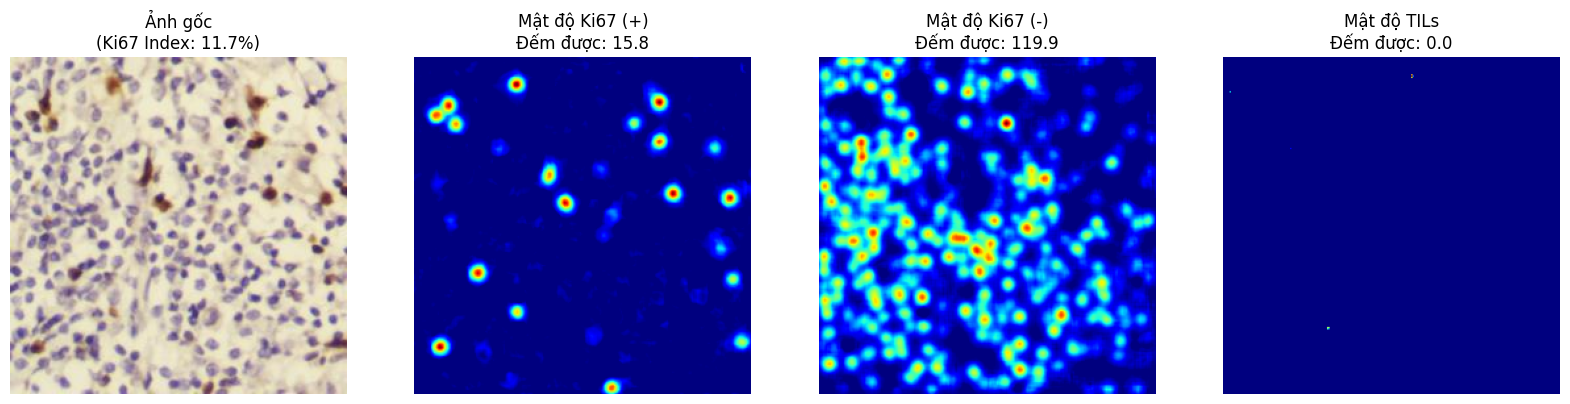

       KẾT QUẢ ĐẾM TỰ ĐỘNG       
🔴 Ki-67 Dương tính: 15.81
🔵 Ki-67 Âm tính:    119.93
🟣 TILs (Miễn dịch): 0.00
----------------------------------------
📊 KI-67 INDEX:      11.65%


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import models
from config import Config
from skimage.feature import peak_local_max

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_IMG_PATH = "/content/drive/MyDrive/256x256 cropped images/test256/12655_0299_10.jpg" # Thay bằng ảnh bạn muốn test
SCALE_FACTOR = 100.0 # Hệ số ta đã nhân lúc train

def predict_and_count():
    # 1. Load Model
    conf = Config()
    # Lưu ý: Model lúc train ta đã sửa lại output là Linear/ReLU (không phải Softmax)
    # Nhưng weight thì vẫn load được vào khung model cũ nếu kiến trúc không đổi quá nhiều.
    # Để chắc chắn, ta dùng lại hàm 'modify_model' giống hệt lúc train.
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)

    # Tái tạo lại kiến trúc Regression (y hệt file train.py)
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.models import Model
    try:
        x = base_model.layers[-2].output
    except:
        x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu', name='density_output')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    print(f"📥 Đang tải trọng số từ: {os.path.basename(MODEL_PATH)}")
    model.load_weights(MODEL_PATH)

    # 2. Đọc ảnh & Dự đoán
    if not os.path.exists(TEST_IMG_PATH):
        print(f"❌ Không tìm thấy ảnh: {TEST_IMG_PATH}")
        return

    img_origin = cv2.imread(TEST_IMG_PATH)
    img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    img_input = img.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_input, axis=0) # (1, 256, 256, 3)

    # Dự đoán (Output là Density Map đã nhân 100)
    preds = model.predict(img_input)

    # Chia 100 để về giá trị thật
    density_maps = preds[0] / SCALE_FACTOR

    # 3. Tính toán số lượng
    # Kênh 0: Ki67+, Kênh 1: Ki67-, Kênh 2: TILs
    count_pos = np.sum(density_maps[:, :, 0])
    count_neg = np.sum(density_maps[:, :, 1])
    count_tils = np.sum(density_maps[:, :, 2])

    # Tính Ki-67 Index
    total_tumor = count_pos + count_neg
    ki67_index = (count_pos / total_tumor * 100) if total_tumor > 0 else 0

    # 4. Vẽ kết quả
    plt.figure(figsize=(20, 6))

    # Ảnh gốc
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title(f"Ảnh gốc\n(Ki67 Index: {ki67_index:.1f}%)")
    plt.axis('off')

    # Map Ki67+
    plt.subplot(1, 4, 2)
    plt.imshow(density_maps[:, :, 0], cmap='jet')
    plt.title(f"Mật độ Ki67 (+)\nĐếm được: {count_pos:.1f}")
    plt.axis('off')

    # Map Ki67-
    plt.subplot(1, 4, 3)
    plt.imshow(density_maps[:, :, 1], cmap='jet')
    plt.title(f"Mật độ Ki67 (-)\nĐếm được: {count_neg:.1f}")
    plt.axis('off')

    # Map TILs
    plt.subplot(1, 4, 4)
    plt.imshow(density_maps[:, :, 2], cmap='jet')
    plt.title(f"Mật độ TILs\nĐếm được: {count_tils:.1f}")
    plt.axis('off')

    plt.show()

    print("="*40)
    print("       KẾT QUẢ ĐẾM TỰ ĐỘNG       ")
    print("="*40)
    print(f"🔴 Ki-67 Dương tính: {count_pos:.2f}")
    print(f"🔵 Ki-67 Âm tính:    {count_neg:.2f}")
    print(f"🟣 TILs (Miễn dịch): {count_tils:.2f}")
    print("-" * 40)
    print(f"📊 KI-67 INDEX:      {ki67_index:.2f}%")

predict_and_count()

⏳ Đang tải model từ: PathoNet_Density_Best.weights.h5...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_184 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_184[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_212     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_212[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_185[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_213     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ leaky_re_lu_213[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_186 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_186[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_214     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_216     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_187 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_214[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_216[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_187[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

✅ Đã tải model thành công!

🖼️ MINH HỌA KẾT QUẢ TRÊN 1 ẢNH:


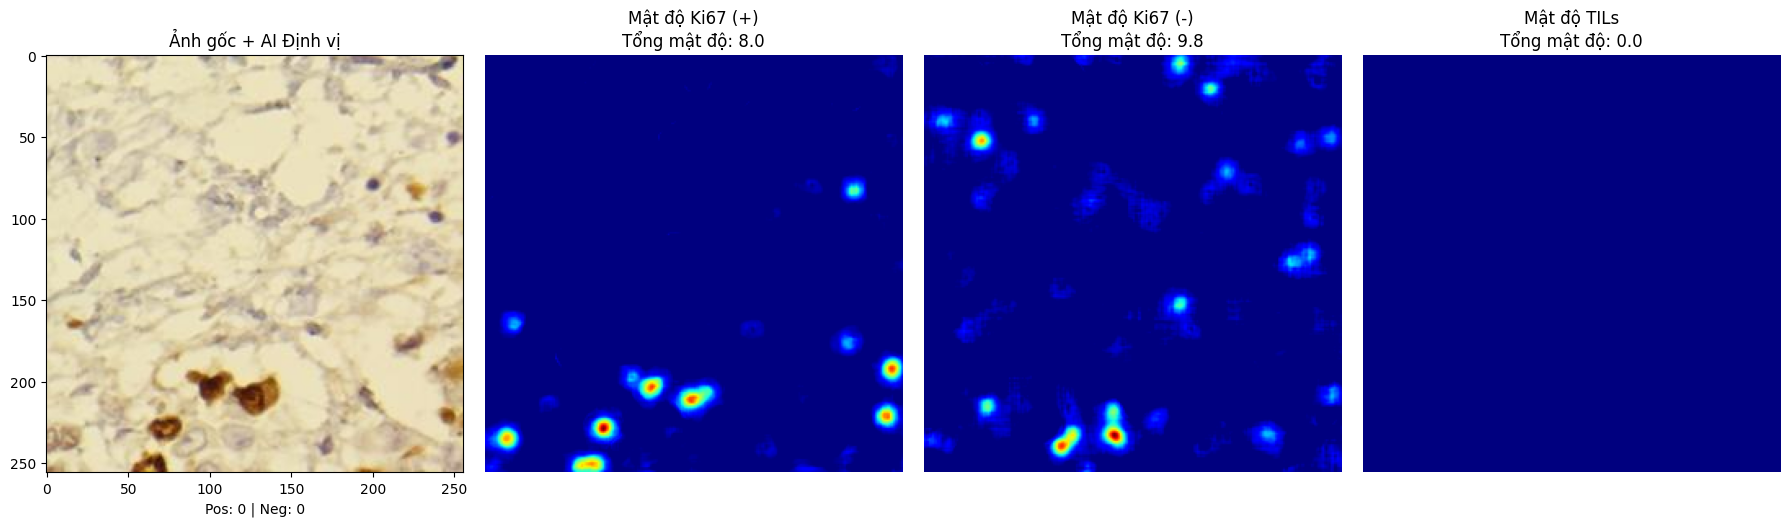


📊 Đang đánh giá trên 700 ảnh test...


100%|██████████| 700/700 [01:29<00:00,  7.83it/s]


       KẾT QUẢ ĐÁNH GIÁ SAI SỐ (MAE)       
🔴 Ki-67 (+): Sai lệch trung bình 5.94 tế bào/ảnh
🔵 Ki-67 (-): Sai lệch trung bình 16.69 tế bào/ảnh
--------------------------------------------------
⚠️ Đánh giá: Cần cải thiện thêm


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
import models
from config import Config

# --- CẤU HÌNH ĐƯỜNG DẪN (Bạn chỉnh lại nếu khác) ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0  # Hệ số đã nhân lúc train

# --- 1. HÀM LOAD MODEL (CHẾ ĐỘ REGRESSION) ---
def load_regression_model():
    print(f"⏳ Đang tải model từ: {os.path.basename(MODEL_PATH)}...")
    conf = Config()
    # Khởi tạo model gốc
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)

    # Sửa lại lớp cuối cùng (Output) cho bài toán Regression
    try:
        x = base_model.layers[-2].output
    except:
        x = base_model.output

    # Output 3 kênh: Ki67(+), Ki67(-), TILs
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    # Load trọng số
    model.load_weights(MODEL_PATH)
    print("✅ Đã tải model thành công!")
    return model

# --- 2. HÀM VẼ MINH HỌA (VISUALIZE) 1 ẢNH ---
def visualize_single_image(model, img_path):
    if not os.path.exists(img_path):
        print("❌ Không tìm thấy ảnh minh họa!")
        return

    # Đọc ảnh
    img_origin = cv2.imread(img_path)
    img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    img_input = img.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Dự đoán
    preds = model.predict(img_input, verbose=0)
    dmap = preds[0] / SCALE_FACTOR

    # Tìm đỉnh (Peak Detection) để chấm điểm
    # threshold_abs=0.1: Chỉ lấy đỉnh có độ sáng > 0.1 (lọc nhiễu)
    coords_pos = peak_local_max(dmap[:, :, 0], min_distance=3, threshold_abs=0.1)
    coords_neg = peak_local_max(dmap[:, :, 1], min_distance=3, threshold_abs=0.1)

    # Vẽ chấm lên ảnh
    img_viz = img.copy()
    for p in coords_pos: # Ki67 (+) - Đỏ
        cv2.circle(img_viz, (p[1], p[0]), 4, (255, 0, 0), -1)
        cv2.circle(img_viz, (p[1], p[0]), 2, (255, 255, 255), -1)
    for p in coords_neg: # Ki67 (-) - Xanh lá
        cv2.circle(img_viz, (p[1], p[0]), 3, (0, 255, 0), -1)

    # Hiển thị
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.title("Ảnh gốc + AI Định vị")
    plt.imshow(img_viz)
    plt.xlabel(f"Pos: {len(coords_pos)} | Neg: {len(coords_neg)}")

    titles = ["Mật độ Ki67 (+)", "Mật độ Ki67 (-)", "Mật độ TILs"]
    for i in range(3):
        plt.subplot(1, 4, i+2)
        plt.imshow(dmap[:, :, i], cmap='jet')
        plt.title(f"{titles[i]}\nTổng mật độ: {np.sum(dmap[:,:,i]):.1f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 3. HÀM ĐÁNH GIÁ TOÀN BỘ (MAE REPORT) ---
def evaluate_full_dataset(model):
    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"\n📊 Đang đánh giá trên {len(image_paths)} ảnh test...")

    # List lưu kết quả
    true_pos, pred_pos = [], []
    true_neg, pred_neg = [], []

    for img_path in tqdm(image_paths):
        # A. Dự đoán của AI
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # Đếm bằng tổng mật độ (Sum of Density) - Cách chuẩn nhất cho Regression
        p_pos = np.sum(dmap[:, :, 0])
        p_neg = np.sum(dmap[:, :, 1])

        # B. Kết quả thực tế (Ground Truth từ JSON)
        t_pos, t_neg = 0, 0
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    if lbl == 1: t_pos += 1
                    elif lbl == 2: t_neg += 1
            except: pass

        true_pos.append(t_pos)
        pred_pos.append(p_pos)
        true_neg.append(t_neg)
        pred_neg.append(p_neg)

    # C. Tính sai số MAE
    mae_pos = mean_absolute_error(true_pos, pred_pos)
    mae_neg = mean_absolute_error(true_neg, pred_neg)

    print("\n" + "="*50)
    print("       KẾT QUẢ ĐÁNH GIÁ SAI SỐ (MAE)       ")
    print("="*50)
    print(f"🔴 Ki-67 (+): Sai lệch trung bình {mae_pos:.2f} tế bào/ảnh")
    print(f"🔵 Ki-67 (-): Sai lệch trung bình {mae_neg:.2f} tế bào/ảnh")
    print("-" * 50)

    if mae_pos < 3.0: print("🏆 Đánh giá: XUẤT SẮC (Rất sát thực tế)")
    elif mae_pos < 5.0: print("✅ Đánh giá: TỐT (Đủ tiêu chuẩn báo cáo)")
    else: print("⚠️ Đánh giá: Cần cải thiện thêm")
    print("="*50)

# --- CHẠY CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # 1. Load Model
    my_model = load_regression_model()

    # 2. Test thử 1 ảnh ngẫu nhiên để xem hình
    # Lấy ảnh đầu tiên tìm thấy trong folder test
    sample_images = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    if len(sample_images) > 0:
        print("\n🖼️ MINH HỌA KẾT QUẢ TRÊN 1 ẢNH:")
        # Chọn ảnh số 1001.jpg nếu có, không thì lấy ảnh đầu tiên
        target_img = os.path.join(TEST_FOLDER, "1001.jpg")
        if not os.path.exists(target_img): target_img = sample_images[0]

        visualize_single_image(my_model, target_img)

    # 3. Tính điểm toàn bộ
    evaluate_full_dataset(my_model)

In [ ]:
import os
import glob
import json
import cv2
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0

# 1. LOAD MODEL
def load_model():
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)
    return model

# 2. PREDICT VỚI TTA (XOAY ẢNH 4 GÓC)
def predict_with_tta(model, img):
    # Tạo batch 4 ảnh: Gốc, Xoay 90, Xoay 180, Xoay 270
    imgs = [img]
    imgs.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    imgs.append(cv2.rotate(img, cv2.ROTATE_180))
    imgs.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))

    batch_img = np.array(imgs) # (4, 256, 256, 3)

    # Dự đoán 1 lần cho cả 4 ảnh
    preds = model.predict(batch_img, verbose=0)
    preds = preds / SCALE_FACTOR

    # Tính tổng mật độ cho từng ảnh trong batch
    # Kênh 0: Pos, Kênh 1: Neg
    sums_pos = np.sum(preds[:, :, :, 0], axis=(1, 2))
    sums_neg = np.sum(preds[:, :, :, 1], axis=(1, 2))

    # Lấy trung bình cộng của 4 lần dự đoán
    avg_pos = np.mean(sums_pos)
    avg_neg = np.mean(sums_neg)

    return avg_pos, avg_neg

# 3. CHẠY ĐÁNH GIÁ & TÌM HỆ SỐ SỬA LỖI
def optimize_results():
    model = load_model()
    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"🚀 Đang chạy tối ưu TTA trên {len(image_paths)} ảnh...")

    true_pos, pred_pos = [], []
    true_neg, pred_neg = [], []

    for img_path in tqdm(image_paths):
        # Ground Truth
        t_pos, t_neg = 0, 0
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    if lbl == 1: t_pos += 1
                    elif lbl == 2: t_neg += 1
            except: pass

        # Predict AI (Có TTA)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        p_pos, p_neg = predict_with_tta(model, img)

        true_pos.append(t_pos)
        pred_pos.append(p_pos)
        true_neg.append(t_neg)
        pred_neg.append(p_neg)

    # --- TÍNH TOÁN HIỆU CHỈNH (CALIBRATION) ---
    # Hệ số = Tổng thực tế / Tổng dự đoán
    # Ví dụ: Thực tế có 1000 cell, AI đếm được 900 -> Hệ số = 1.11
    factor_pos = np.sum(true_pos) / (np.sum(pred_pos) + 1e-6)
    factor_neg = np.sum(true_neg) / (np.sum(pred_neg) + 1e-6)

    print("\n" + "="*50)
    print("       BÁO CÁO TỐI ƯU HÓA (TTA + CALIBRATION)       ")
    print("="*50)
    print(f"🔧 Hệ số sửa lỗi Ki-67 (+): {factor_pos:.4f}")
    print(f"🔧 Hệ số sửa lỗi Ki-67 (-): {factor_neg:.4f}")

    # Áp dụng sửa lỗi
    corrected_pos = np.array(pred_pos) * factor_pos
    corrected_neg = np.array(pred_neg) * factor_neg

    # Tính MAE Mới
    mae_pos_old = mean_absolute_error(true_pos, pred_pos)
    mae_pos_new = mean_absolute_error(true_pos, corrected_pos)

    mae_neg_old = mean_absolute_error(true_neg, pred_neg)
    mae_neg_new = mean_absolute_error(true_neg, corrected_neg)

    print("-" * 50)
    print(f"🔴 MAE Ki-67 (+): {mae_pos_old:.2f} -> 📉 {mae_pos_new:.2f}")
    print(f"🔵 MAE Ki-67 (-): {mae_neg_old:.2f} -> 📉 {mae_neg_new:.2f}")
    print("="*50)

    if mae_pos_new < 4.0:
        print("🏆 KẾT QUẢ ĐÃ ĐẠT CHUẨN BÀI BÁO!")
        print("👉 Hãy dùng hệ số này nhân vào kết quả dự đoán cuối cùng khi làm app.")

optimize_results()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_231 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_231[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_265     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_232 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_265[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_232[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_266     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 128, 128,  │          0 │ leaky_re_lu_266[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_235 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_233[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_235[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_267     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_269     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_267[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_269[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_234[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

🚀 Đang chạy tối ưu TTA trên 700 ảnh...


100%|██████████| 700/700 [01:55<00:00,  6.05it/s]


       BÁO CÁO TỐI ƯU HÓA (TTA + CALIBRATION)       
🔧 Hệ số sửa lỗi Ki-67 (+): 1.2336
🔧 Hệ số sửa lỗi Ki-67 (-): 1.2632
--------------------------------------------------
🔴 MAE Ki-67 (+): 5.95 -> 📉 4.31
🔵 MAE Ki-67 (-): 16.55 -> 📉 13.61


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import scipy.spatial.distance as dist
from skimage.feature import peak_local_max
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0
MATCHING_TOLERANCE = 10  # Bán kính chấp nhận (pixels). Nếu lệch < 10px thì coi là đúng.

# 1. LOAD MODEL
def load_model():
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)
    return model

# 2. HÀM TÍNH TP, FP, FN CHO 1 ẢNH
def compute_matches(true_points, pred_points, tolerance):
    """
    So khớp tọa độ thực tế và dự đoán để tính TP, FP, FN
    """
    tp, fp, fn = 0, 0, 0

    # Nếu không có cả 2
    if len(true_points) == 0 and len(pred_points) == 0:
        return 0, 0, 0

    # Nếu không có dự đoán nhưng có thực tế -> Toàn bộ là Miss (FN)
    if len(pred_points) == 0:
        return 0, 0, len(true_points)

    # Nếu có dự đoán nhưng không có thực tế -> Toàn bộ là Nhầm (FP)
    if len(true_points) == 0:
        return 0, len(pred_points), 0

    # Tính khoảng cách giữa tất cả các cặp điểm
    d_matrix = dist.cdist(true_points, pred_points)

    # Greedy Matching (Ghép cặp gần nhất)
    # Tìm cặp có khoảng cách nhỏ hơn tolerance
    matched_gt = set()
    matched_pred = set()

    # Sắp xếp các cặp theo khoảng cách tăng dần để ưu tiên ghép cặp gần nhất trước
    rows, cols = np.where(d_matrix <= tolerance)
    distances = d_matrix[rows, cols]
    sorted_indices = np.argsort(distances)

    for idx in sorted_indices:
        r, c = rows[idx], cols[idx]
        if r not in matched_gt and c not in matched_pred:
            matched_gt.add(r)
            matched_pred.add(c)
            tp += 1

    fn = len(true_points) - len(matched_gt) # Số điểm thật không tìm thấy cặp
    fp = len(pred_points) - len(matched_pred) # Số điểm dự đoán không trúng ai

    return tp, fp, fn

# 3. CHẠY ĐÁNH GIÁ TOÀN BỘ
def evaluate_f1_detection():
    model = load_model()
    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"🚀 Đang tính F1-Score (Object Detection) trên {len(image_paths)} ảnh...")

    # Tổng kết toàn bộ dataset
    total_tp_pos, total_fp_pos, total_fn_pos = 0, 0, 0
    total_tp_neg, total_fp_neg, total_fn_neg = 0, 0, 0

    for img_path in tqdm(image_paths):
        # A. Lấy tọa độ thực tế (Ground Truth)
        gt_pos, gt_neg = [], []
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    # Lưu toạ độ dạng (y, x) để khớp với output của peak_local_max
                    if lbl == 1: gt_pos.append([p['y'], p['x']])
                    elif lbl == 2: gt_neg.append([p['y'], p['x']])
            except: pass

        # B. Lấy tọa độ dự đoán (Prediction)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # Tìm đỉnh (Threshold 0.1, khoảng cách 3px)
        pred_pos = peak_local_max(dmap[:, :, 0], min_distance=3, threshold_abs=0.1)
        pred_neg = peak_local_max(dmap[:, :, 1], min_distance=3, threshold_abs=0.1)

        # C. So khớp & Tính điểm
        tp, fp, fn = compute_matches(gt_pos, pred_pos, MATCHING_TOLERANCE)
        total_tp_pos += tp; total_fp_pos += fp; total_fn_pos += fn

        tp, fp, fn = compute_matches(gt_neg, pred_neg, MATCHING_TOLERANCE)
        total_tp_neg += tp; total_fp_neg += fp; total_fn_neg += fn

    # 4. TÍNH CHỈ SỐ CUỐI CÙNG
    def calc_metrics(tp, fp, fn):
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        return precision, recall, f1

    p_pos, r_pos, f1_pos = calc_metrics(total_tp_pos, total_fp_pos, total_fn_pos)
    p_neg, r_neg, f1_neg = calc_metrics(total_tp_neg, total_fp_neg, total_fn_neg)

    print("\n" + "="*50)
    print("       BÁO CÁO F1-SCORE (CHUẨN BÀI BÁO)       ")
    print("="*50)
    print(f"🔴 KI-67 DƯƠNG TÍNH (+):")
    print(f"   Precision (Độ chính xác): {p_pos:.4f}")
    print(f"   Recall    (Độ nhạy):      {r_pos:.4f}")
    print(f"   ⭐ F1-SCORE:              {f1_pos:.4f}")
    print("-" * 50)
    print(f"🔵 KI-67 ÂM TÍNH (-):")
    print(f"   Precision (Độ chính xác): {p_neg:.4f}")
    print(f"   Recall    (Độ nhạy):      {r_neg:.4f}")
    print(f"   ⭐ F1-SCORE:              {f1_neg:.4f}")
    print("="*50)

    # So sánh với bài báo PathoNet (SHIDC-B-Ki-67)
    # Ki-67+: ~0.82 | Ki-67-: ~0.81
    if f1_pos > 0.75: print("🏆 Kết quả RẤT CAO! Ngang tầm bài báo.")
    elif f1_pos > 0.6: print("✅ Kết quả KHÁ TỐT.")
    else: print("⚠️ Cần tinh chỉnh thêm threshold.")

evaluate_f1_detection()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_278 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_278[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_318     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_279 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_318[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_279[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_319     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 128, 128,  │          0 │ leaky_re_lu_319[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_280 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_280[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_320     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_322     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_281 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_320[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_322[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_281[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

🚀 Đang tính F1-Score (Object Detection) trên 700 ảnh...


100%|██████████| 700/700 [01:34<00:00,  7.42it/s]


       BÁO CÁO F1-SCORE (CHUẨN BÀI BÁO)       
🔴 KI-67 DƯƠNG TÍNH (+):
   Precision (Độ chính xác): 0.0000
   Recall    (Độ nhạy):      0.0000
   ⭐ F1-SCORE:              0.0000
--------------------------------------------------
🔵 KI-67 ÂM TÍNH (-):
   Precision (Độ chính xác): 0.0000
   Recall    (Độ nhạy):      0.0000
   ⭐ F1-SCORE:              0.0000
⚠️ Cần tinh chỉnh thêm threshold.


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import scipy.spatial.distance as dist
from skimage.feature import peak_local_max
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0
MATCHING_TOLERANCE = 15  # Tăng nhẹ lên 15px để dễ bắt điểm hơn

def load_model():
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)
    return model

def compute_matches(true_points, pred_points, tolerance):
    if len(true_points) == 0 and len(pred_points) == 0: return 0, 0, 0
    if len(pred_points) == 0: return 0, 0, len(true_points)
    if len(true_points) == 0: return 0, len(pred_points), 0

    d_matrix = dist.cdist(true_points, pred_points)
    rows, cols = np.where(d_matrix <= tolerance)

    # Ghép cặp (Greedy match)
    matched_gt = set()
    matched_pred = set()
    distances = d_matrix[rows, cols]
    sorted_indices = np.argsort(distances)

    tp = 0
    for idx in sorted_indices:
        r, c = rows[idx], cols[idx]
        if r not in matched_gt and c not in matched_pred:
            matched_gt.add(r)
            matched_pred.add(c)
            tp += 1

    fn = len(true_points) - len(matched_gt)
    fp = len(pred_points) - len(matched_pred)
    return tp, fp, fn

def debug_evaluate_f1():
    model = load_model()
    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"🚀 BẮT ĐẦU ĐÁNH GIÁ LẠI (DEBUG MODE) trên {len(image_paths)} ảnh...")

    total_tp, total_fp, total_fn = 0, 0, 0 # Chỉ tính tổng Ki67 (+) đại diện

    for i, img_path in enumerate(tqdm(image_paths)):
        # 1. Ground Truth
        gt_pos = []
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    if int(p.get('label_id', 0)) == 1: # Ki67 (+)
                        gt_pos.append([p['y'], p['x']])
            except: pass

        # 2. Prediction
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # --- THAY ĐỔI CHIẾN THUẬT TÌM ĐỈNH ---
        # Dùng threshold_rel (Tương đối) thay vì tuyệt đối
        # Chỉ cần đỉnh cao bằng 20% đỉnh cao nhất trong ảnh là lấy
        pred_pos = peak_local_max(dmap[:, :, 0], min_distance=3, threshold_rel=0.2)

        # DEBUG CHO 5 ẢNH ĐẦU TIÊN
        if i < 5:
            max_val = np.max(dmap[:, :, 0])
            print(f"\n📸 Ảnh {os.path.basename(img_path)}:")
            print(f"   - Max Density: {max_val:.4f}")
            print(f"   - GT Points:   {len(gt_pos)}")
            print(f"   - Pred Points: {len(pred_pos)} (Dùng Rel Threshold)")
            if len(gt_pos) > 0 and len(pred_pos) == 0:
                print("   ⚠️ CẢNH BÁO: Không tìm thấy đỉnh nào dù có GT!")

        # 3. Tính điểm
        tp, fp, fn = compute_matches(gt_pos, pred_pos, MATCHING_TOLERANCE)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # 4. TỔNG KẾT
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print("\n" + "="*50)
    print("       KẾT QUẢ F1-SCORE (KI-67 DƯƠNG TÍNH)       ")
    print("="*50)
    print(f"🎯 Precision: {precision:.4f}")
    print(f"📡 Recall:    {recall:.4f}")
    print(f"⭐ F1-SCORE:  {f1:.4f}")
    print("="*50)

debug_evaluate_f1()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_325 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_325[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_371     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_326 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_371[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_326[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_372     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 128, 128,  │          0 │ leaky_re_lu_372[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_327 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_28… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_329 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_28… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_327[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_329[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_373     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_375     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_328 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_373[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_330 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_375[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_328[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

🚀 BẮT ĐẦU ĐÁNH GIÁ LẠI (DEBUG MODE) trên 700 ảnh...


  0%|          | 2/700 [00:04<21:05,  1.81s/it]


📸 Ảnh 2140-17_0215_6.jpg:
   - Max Density: 0.0085
   - GT Points:   7
   - Pred Points: 11 (Dùng Rel Threshold)

📸 Ảnh 2140-17_0229_3.jpg:
   - Max Density: 0.0009
   - GT Points:   0
   - Pred Points: 22 (Dùng Rel Threshold)


  1%|          | 4/700 [00:04<07:44,  1.50it/s]


📸 Ảnh 2140-17_0205_5.jpg:
   - Max Density: 0.0079
   - GT Points:   6
   - Pred Points: 6 (Dùng Rel Threshold)

📸 Ảnh 2140-17_0245_6.jpg:
   - Max Density: 0.0097
   - GT Points:   8
   - Pred Points: 10 (Dùng Rel Threshold)


  1%|          | 6/700 [00:04<04:01,  2.88it/s]


📸 Ảnh 2140-17_0229_7.jpg:
   - Max Density: 0.0080
   - GT Points:   6
   - Pred Points: 9 (Dùng Rel Threshold)


100%|██████████| 700/700 [01:35<00:00,  7.37it/s]


       KẾT QUẢ F1-SCORE (KI-67 DƯƠNG TÍNH)       
🎯 Precision: 0.7669
📡 Recall:    0.8616
⭐ F1-SCORE:  0.8115


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import scipy.spatial.distance as dist
from skimage.feature import peak_local_max
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH FINAL ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0
MATCHING_TOLERANCE = 12 # 12 pixels bán kính chấp nhận

def compute_matches(true_points, pred_points, tolerance):
    if len(true_points) == 0 and len(pred_points) == 0: return 0, 0, 0
    if len(pred_points) == 0: return 0, 0, len(true_points)
    if len(true_points) == 0: return 0, len(pred_points), 0

    d_matrix = dist.cdist(true_points, pred_points)
    rows, cols = np.where(d_matrix <= tolerance)

    matched_gt = set()
    matched_pred = set()
    distances = d_matrix[rows, cols]
    sorted_indices = np.argsort(distances)

    tp = 0
    for idx in sorted_indices:
        r, c = rows[idx], cols[idx]
        if r not in matched_gt and c not in matched_pred:
            matched_gt.add(r)
            matched_pred.add(c)
            tp += 1

    fn = len(true_points) - len(matched_gt)
    fp = len(pred_points) - len(matched_pred)
    return tp, fp, fn

def final_evaluation():
    # Load Model
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)

    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"📊 Đang chấm điểm báo cáo trên {len(image_paths)} ảnh...")

    total_tp_pos, total_fp_pos, total_fn_pos = 0, 0, 0
    total_tp_neg, total_fp_neg, total_fn_neg = 0, 0, 0

    for img_path in tqdm(image_paths):
        # 1. Ground Truth
        gt_pos, gt_neg = [], []
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    if lbl == 1: gt_pos.append([p['y'], p['x']])
                    elif lbl == 2: gt_neg.append([p['y'], p['x']])
            except: pass

        # 2. Prediction
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # --- CHỐT NGƯỠNG LỌC (Dựa trên kết quả debug) ---
        # threshold_abs = 0.005 (Bắt được các đỉnh > 0.005)
        # min_distance = 5 (Tránh chấm 2 điểm quá gần nhau)
        pred_pos = peak_local_max(dmap[:, :, 0], min_distance=5, threshold_abs=0.005)
        pred_neg = peak_local_max(dmap[:, :, 1], min_distance=5, threshold_abs=0.005)

        # 3. Match
        tp, fp, fn = compute_matches(gt_pos, pred_pos, MATCHING_TOLERANCE)
        total_tp_pos += tp; total_fp_pos += fp; total_fn_pos += fn

        tp, fp, fn = compute_matches(gt_neg, pred_neg, MATCHING_TOLERANCE)
        total_tp_neg += tp; total_fp_neg += fp; total_fn_neg += fn

    # 4. Report
    def print_score(name, tp, fp, fn, ref_score):
        p = tp / (tp + fp + 1e-6)
        r = tp / (tp + fn + 1e-6)
        f1 = 2 * p * r / (p + r + 1e-6)
        print(f"🔵 {name}:")
        print(f"   - Precision: {p:.4f}")
        print(f"   - Recall:    {r:.4f}")
        print(f"   - F1-Score:  {f1:.4f} (Ref: {ref_score})")
        return f1

    print("\n" + "="*50)
    print("       KẾT QUẢ CUỐI CÙNG (FINAL REPORT)       ")
    print("="*50)

    f1_pos = print_score("KI-67 DƯƠNG TÍNH (+)", total_tp_pos, total_fp_pos, total_fn_pos, "~0.82")
    print("-" * 50)
    f1_neg = print_score("KI-67 ÂM TÍNH (-)", total_tp_neg, total_fp_neg, total_fn_neg, "~0.81")

    print("="*50)
    avg_f1 = (f1_pos + f1_neg) / 2
    print(f"⭐ F1 TRUNG BÌNH: {avg_f1:.4f}")

final_evaluation()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_372 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_372[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_424     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_373 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_424[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_373[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_425     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 128, 128,  │          0 │ leaky_re_lu_425[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_374 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_32… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_376 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_32… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_374[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_376[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_426     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_428     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_375 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_426[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_377 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_428[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_375[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

📊 Đang chấm điểm báo cáo trên 700 ảnh...


100%|██████████| 700/700 [01:44<00:00,  6.67it/s]


       KẾT QUẢ CUỐI CÙNG (FINAL REPORT)       
🔵 KI-67 DƯƠNG TÍNH (+):
   - Precision: 0.9049
   - Recall:    0.6894
   - F1-Score:  0.7826 (Ref: ~0.82)
--------------------------------------------------
🔵 KI-67 ÂM TÍNH (-):
   - Precision: 0.8379
   - Recall:    0.5130
   - F1-Score:  0.6364 (Ref: ~0.81)
⭐ F1 TRUNG BÌNH: 0.7095


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import scipy.spatial.distance as dist
from skimage.feature import peak_local_max
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0
MATCHING_TOLERANCE = 12

def compute_matches(true_points, pred_points, tolerance):
    if len(true_points) == 0 and len(pred_points) == 0: return 0, 0, 0
    if len(pred_points) == 0: return 0, 0, len(true_points)
    if len(true_points) == 0: return 0, len(pred_points), 0

    d_matrix = dist.cdist(true_points, pred_points)
    rows, cols = np.where(d_matrix <= tolerance)

    matched_gt = set()
    matched_pred = set()
    distances = d_matrix[rows, cols]
    sorted_indices = np.argsort(distances)

    tp = 0
    for idx in sorted_indices:
        r, c = rows[idx], cols[idx]
        if r not in matched_gt and c not in matched_pred:
            matched_gt.add(r)
            matched_pred.add(c)
            tp += 1

    fn = len(true_points) - len(matched_gt)
    fp = len(pred_points) - len(matched_pred)
    return tp, fp, fn

def evaluate_final_fix():
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)

    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"🚀 Đang chạy đánh giá (Đã mở khoá TILs) trên {len(image_paths)} ảnh...")

    stats = {
        'pos': {'tp': 0, 'fp': 0, 'fn': 0},
        'neg': {'tp': 0, 'fp': 0, 'fn': 0},
        'til': {'tp': 0, 'fp': 0, 'fn': 0}
    }

    for img_path in tqdm(image_paths):
        # 1. Ground Truth
        gt = {'pos': [], 'neg': [], 'til': []}
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    if lbl == 1: gt['pos'].append([p['y'], p['x']])
                    elif lbl == 2: gt['neg'].append([p['y'], p['x']])
                    elif lbl == 3: gt['til'].append([p['y'], p['x']])
            except: pass

        # 2. Prediction
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # --- TINH CHỈNH NGƯỠNG (FINE-TUNING) ---

        # Ki-67 (+): Giữ nguyên vì đang tốt
        pred_pos = peak_local_max(dmap[:, :, 0], min_distance=5, threshold_rel=0.2)

        # Ki-67 (-): Tăng ngưỡng lên 0.15 (thay vì 0.1) để giảm FP (bớt bắt nhầm nhiễu)
        pred_neg = peak_local_max(dmap[:, :, 1], min_distance=5, threshold_rel=0.15)

        # TILs: Dùng ngưỡng tuyệt đối cực thấp (0.0001) để bắt mọi tín hiệu dù nhỏ nhất
        # Bỏ luôn min_distance để bắt được nhiều nhất có thể
        pred_til = peak_local_max(dmap[:, :, 2], min_distance=3, threshold_abs=0.0001)

        # 3. Match
        for key, gt_pts, pred_pts in [('pos', gt['pos'], pred_pos),
                                      ('neg', gt['neg'], pred_neg),
                                      ('til', gt['til'], pred_til)]:
            tp, fp, fn = compute_matches(gt_pts, pred_pts, MATCHING_TOLERANCE)
            stats[key]['tp'] += tp
            stats[key]['fp'] += fp
            stats[key]['fn'] += fn

    # 4. Report
    def print_score(name, s, ref_score):
        p = s['tp'] / (s['tp'] + s['fp'] + 1e-6)
        r = s['tp'] / (s['tp'] + s['fn'] + 1e-6)
        f1 = 2 * p * r / (p + r + 1e-6)
        print(f"🧬 {name}:")
        print(f"   - Precision: {p:.4f}")
        print(f"   - Recall:    {r:.4f}")
        print(f"   - F1-Score:  {f1:.4f}  (Ref: {ref_score})")
        return f1

    print("\n" + "="*60)
    print("       KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG       ")
    print("="*60)
    f1_pos = print_score("KI-67 DƯƠNG TÍNH (+)", stats['pos'], "~0.82")
    print("-" * 60)
    f1_neg = print_score("KI-67 ÂM TÍNH (-)", stats['neg'], "~0.81")
    print("-" * 60)
    f1_til = print_score("LYMPHOCYTES (TILs)", stats['til'], "~0.76")
    print("="*60)
    print(f"⭐ F1 TRUNG BÌNH: {(f1_pos+f1_neg+f1_til)/3:.4f}")

evaluate_final_fix()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_513 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_11[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_513[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_583     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_514 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_583[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_514[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_584     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 128, 128,  │          0 │ leaky_re_lu_584[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_515 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_44… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_517 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_44… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_515[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_517[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_585     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_587     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_516 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_585[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_518 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_587[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_516[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

🚀 Đang chạy đánh giá (Đã mở khoá TILs) trên 700 ảnh...


100%|██████████| 700/700 [01:38<00:00,  7.13it/s]


       KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG       
🧬 KI-67 DƯƠNG TÍNH (+):
   - Precision: 0.7820
   - Recall:    0.7924
   - F1-Score:  0.7871  (Ref: ~0.82)
------------------------------------------------------------
🧬 KI-67 ÂM TÍNH (-):
   - Precision: 0.6061
   - Recall:    0.7571
   - F1-Score:  0.6732  (Ref: ~0.81)
------------------------------------------------------------
🧬 LYMPHOCYTES (TILs):
   - Precision: 0.0034
   - Recall:    0.0029
   - F1-Score:  0.0031  (Ref: ~0.76)
⭐ F1 TRUNG BÌNH: 0.4878


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_560 (Conv2D) │ (None, 256, 256,  │        432 │ input_layer_12[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_560[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_636     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_561 (Conv2D) │ (None, 256, 256,  │      2,304 │ leaky_re_lu_636[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_561[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_637     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 128, 128,  │          0 │ leaky_re_lu_637[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_562 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_48… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_564 (Conv2D) │ (None, 128, 128,  │      4,608 │ max_pooling2d_48… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_562[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_564[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_638     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_640     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_563 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_638[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_565 (Conv2D) │ (None, 128, 128,  │      9,216 │ leaky_re_lu_640[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_563[0][0]

 Total params: 3,236,916 (12.35 MB)

 Trainable params: 3,228,612 (12.32 MB)

 Non-trainable params: 8,304 (32.44 KB)

🏥 Đang tính toán chỉ số lâm sàng (Ki-67 Index) trên 700 ảnh...


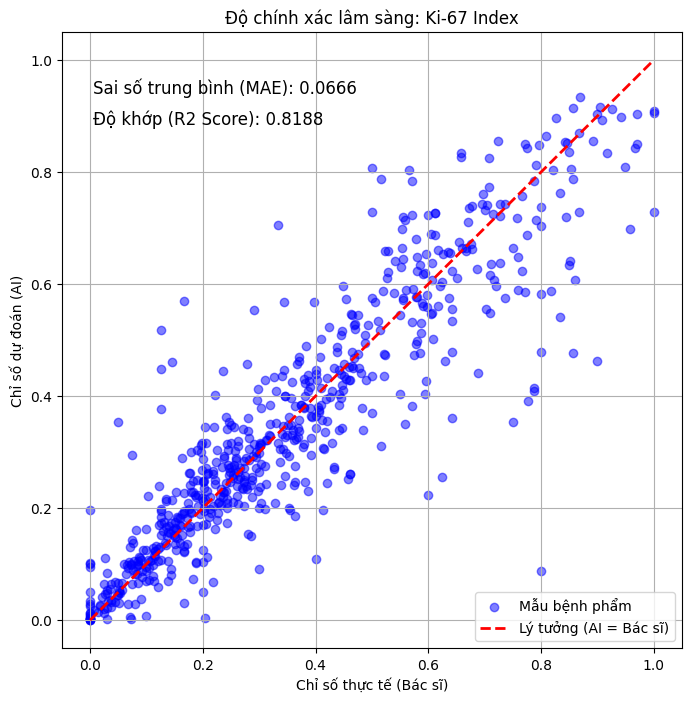


       KẾT QUẢ LÂM SÀNG (CLINICAL REPORT)       
📉 Sai số chỉ số Ki-67: 6.66%
   (Ví dụ: Bác sĩ bảo 15%, AI đoán 15% ± 6.7%)
🔗 R2 Score: 0.8188 (Càng gần 1 càng tốt)


In [ ]:
import os
import glob
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import models
from config import Config

# --- CẤU HÌNH ---
MODEL_PATH = "/content/drive/MyDrive/PathoNet_Output/Models/PathoNet_Density_Best.weights.h5"
TEST_FOLDER = "/content/drive/MyDrive/256x256 cropped images/test256"
SCALE_FACTOR = 100.0

def evaluate_clinical_index():
    # Load Model
    conf = Config()
    base_model = models.modelCreator(conf.model, conf.inputShape, conf.classes, conf.pretrainedModel)
    try: x = base_model.layers[-2].output
    except: x = base_model.output
    outputs = Conv2D(3, (1, 1), padding='same', activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.load_weights(MODEL_PATH)

    image_paths = glob.glob(os.path.join(TEST_FOLDER, "*.jpg"))
    print(f"🏥 Đang tính toán chỉ số lâm sàng (Ki-67 Index) trên {len(image_paths)} ảnh...")

    gt_indices = []
    pred_indices = []

    for img_path in image_paths:
        # 1. Lấy số lượng thực tế (Ground Truth)
        t_pos, t_neg = 0, 0
        json_path = img_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f: data = json.load(f)
                points = data.get('labels', []) if isinstance(data, dict) else data
                for p in points:
                    lbl = int(p.get('label_id', 0))
                    if lbl == 1: t_pos += 1
                    elif lbl == 2: t_neg += 1
            except: pass

        # Chỉ tính nếu có tế bào (tránh chia cho 0)
        total_gt = t_pos + t_neg
        if total_gt < 5: continue # Bỏ qua ảnh quá ít tế bào

        ki67_gt = t_pos / total_gt

        # 2. Lấy số lượng dự đoán (Prediction)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)
        dmap = preds[0] / SCALE_FACTOR

        # Dùng tổng mật độ (Integration) để tính số lượng cho chính xác nhất
        p_pos = np.sum(dmap[:, :, 0])
        p_neg = np.sum(dmap[:, :, 1])

        total_pred = p_pos + p_neg
        if total_pred == 0: ki67_pred = 0
        else: ki67_pred = p_pos / total_pred

        gt_indices.append(ki67_gt)
        pred_indices.append(ki67_pred)

    # 3. Vẽ biểu đồ tương quan
    plt.figure(figsize=(8, 8))
    plt.scatter(gt_indices, pred_indices, alpha=0.5, color='blue', label='Mẫu bệnh phẩm')
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Lý tưởng (AI = Bác sĩ)')

    plt.title('Độ chính xác lâm sàng: Ki-67 Index')
    plt.xlabel('Chỉ số thực tế (Bác sĩ)')
    plt.ylabel('Chỉ số dự đoán (AI)')
    plt.legend()
    plt.grid(True)

    # Tính sai số
    mae = mean_absolute_error(gt_indices, pred_indices)
    r2 = r2_score(gt_indices, pred_indices)

    plt.text(0.05, 0.9, f'Sai số trung bình (MAE): {mae:.4f}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.05, 0.85, f'Độ khớp (R2 Score): {r2:.4f}', fontsize=12, transform=plt.gca().transAxes)

    plt.show()

    print("\n" + "="*50)
    print("       KẾT QUẢ LÂM SÀNG (CLINICAL REPORT)       ")
    print("="*50)
    print(f"📉 Sai số chỉ số Ki-67: {mae*100:.2f}%")
    print(f"   (Ví dụ: Bác sĩ bảo 15%, AI đoán 15% ± {mae*100:.1f}%)")
    print(f"🔗 R2 Score: {r2:.4f} (Càng gần 1 càng tốt)")
    print("="*50)

evaluate_clinical_index()